In [1]:
%load_ext autoreload
%autoreload 2

%cd /home/theo/PBO_project/PBO/
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import jax
import numpy as np
from experiments.lqr.utils import define_environment

experiment_name = "test"
n_gs = 8
g_range = 2
n_is = 8
i_range = 2

p = json.load(open(f"experiments/lqr/figures/{experiment_name}/parameters.json"))

env = define_environment(jax.random.PRNGKey(p["env_seed"]), p["max_discrete_state"])
gs_ = np.linspace(env.optimal_weights[0] - g_range, env.optimal_weights[0] + g_range, n_gs)
is_ = np.linspace(env.optimal_weights[1] - i_range, env.optimal_weights[1] + i_range, n_is)
g_mesh, i_mesh = np.meshgrid(gs_, is_)
weights_ = np.stack((g_mesh, i_mesh), axis=-1).reshape((-1, 2))
weights = np.hstack((weights_, env.optimal_weights[2] * np.ones((weights_.shape[0], 1))))
random_weights = 

/home/theo/PBO_project/PBO


Transition: s' = As + Ba
Transition: s' = -0.45554542541503906s + 0.5418910980224609a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.7250176668167114s² + -0.9326448440551758a² + -0.6272382736206055sa


## Get the optimal PBO

In [2]:
from experiments.lqr.utils import define_q_vector_field
from pbo.networks.learnable_pbo import CustomLinearPBO
from pbo.utils.params import load_params

q = define_q_vector_field(p["n_actions_on_max"], p["max_action_on_max"], env.optimal_weights[2], jax.random.PRNGKey(0))
pbo = CustomLinearPBO(
    q=q,
    max_bellman_iterations=0,
    network_key=jax.random.PRNGKey(0),
    learning_rate={"first": 0, "last": 0, "duration": 0},
    initial_weight_std=0.1,
)
pbo.params["CustomLinearPBONet"]["slope"] = env.optimal_slope.reshape((1, 3))
pbo.params["CustomLinearPBONet"]["bias"] = env.optimal_bias.reshape((1, 3))

iterated_weights = pbo(pbo.params, weights)

In [3]:
env.optimal_weights

DeviceArray([-0.9131093 , -0.08987598, -1.198797  ], dtype=float32)

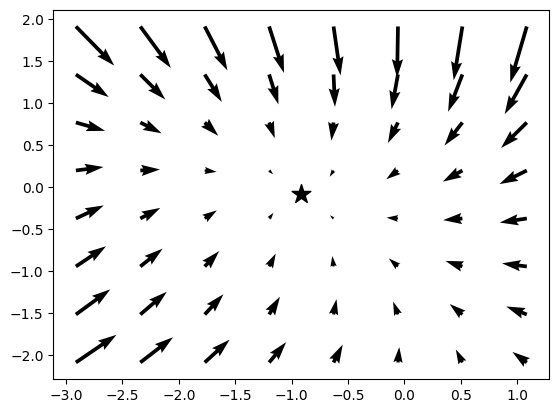

In [9]:
import matplotlib.pyplot as plt

plt.quiver(weights[:, 0], weights[:, 1], iterated_weights[:, 0] - weights[:, 0], iterated_weights[:, 1] - weights[:, 1])
plt.scatter(env.optimal_weights[0], env.optimal_weights[1], marker="*", c="black", s=200)

## Compute PBOs iteration

In [5]:
# from experiments.lqr.utils import define_q_vector_field
# from pbo.networks.learnable_pbo import LinearPBO
# from pbo.utils.params import load_params

# q = define_q_vector_field(p["n_actions_on_max"], p["max_action_on_max"], env.optimal_weights[2], jax.random.PRNGKey(0))

# pbo = LinearPBO(
#     q=q,
#     max_bellman_iterations=0,
#     add_infinity=True,
#     network_key=jax.random.PRNGKey(0),
#     learning_rate={"first": 0, "last": 0, "duration": 0},
#     initial_weight_std=p["initial_weight_std"],
# )
# pbo.params = load_params(
#     f"experiments/lqr/figures/{experiment_name}/PBO_linear/{max_bellman_iterations}_P_0"
# )

# pbo_iterated_weights = pbo(pbo.params, weights)

## Compute optimal Bellman iteration

In [6]:
from experiments.lqr.utils import define_data_loader_samples

data_loader_samples = define_data_loader_samples(
    p["n_discrete_states"] * p["n_discrete_actions"], experiment_name, p["batch_size_samples"], jax.random.PRNGKey(0)
)
Z = np.zeros((p["n_discrete_states"] * p["n_discrete_actions"], 2))
Z[:, 0] = -np.array(data_loader_samples.replay_buffer.states.flatten()) ** 2
Z[:, 1] = -2 * np.array(
    data_loader_samples.replay_buffer.states.flatten() * data_loader_samples.replay_buffer.actions.flatten()
)
invert_Z_Z = np.linalg.inv(Z.T @ Z)

J = np.zeros((p["n_discrete_states"] * p["n_discrete_actions"], 3))
J[:, 0] = np.array(data_loader_samples.replay_buffer.states.flatten()) ** 2
J[:, 1] = 2 * np.array(
    data_loader_samples.replay_buffer.states.flatten() * data_loader_samples.replay_buffer.actions.flatten()
)
J[:, 2] = np.array(data_loader_samples.replay_buffer.actions.flatten()) ** 2

D = np.array(
    [
        [env.A**2, -env.A**2 / env.optimal_weights[2]],
        [env.A * env.B, - env.A * env.B / env.optimal_weights[2]],
        [env.B**2, -env.B**2 / env.optimal_weights[2]],
    ]
)

E = np.array([env.Q, env.S, env.R - env.optimal_weights[2]])
projection = - invert_Z_Z @ Z.T @ J

In [7]:
non_linear_weights = np.zeros_like(weights)
non_linear_weights[:, 0] = weights[:, 0]
non_linear_weights[:, 1] = weights[:, 1] ** 2

bellman_iterated_weights = np.zeros_like(weights)

for idx_weight, weight in enumerate(weights):
    bellman_iterated_weights[idx_weight] = projection @ (D @ non_linear_weights[idx_weight] + E)
    

print(bellman_iterated_weights)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)